<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment 2</b>

    
Thank you for your diligence on this and other sprints! I am very glad to see your progress 😊 I hope you enjoyed working on all these projects and learning data science. 
    
    
    
Good luck! 

    
</div>

<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi, my name is Svetlana (https://hub.tripleten.com/u/6dee602c).  Congratulations on submitting the Final project! 🎉 

    
<div style="border: 5px solid green; padding: 15px; margin: 5px">

- You did a great job on building a good model for churn prediction.


- The notebook demonstrates strong fundamentals: clean data merging, thoughtful preprocessing, train-test splitting, and meaningful metric evaluation.


    
- It is very good that you add EDA. Distributions and feature correlations may provide helpful context before modeling. In real-world problems, the data is rarely clean. Displaying distributions help us evaluate the data, find outliers, identify the required preprocessing steps and understand feature relationships, which informs feature engineering. Feature engineering in some cases is a clue.    


- The data was merged correctly!


- `OrdinalEncoder` is a great choice, well done! It is also correct that you apply it after you split the data to prevent data leakage.
  
    
- Hyperparameters tuning was implemented correctly, good! 
    


</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

What can be improved:


- Consider writing an introduction to enhance the readability of your project :) 


- In the EDA section, conclusions would not be redundant as well. EDA defines feature engineering, so it's quite important.
 


- Before training real models, it's useful to evaluate a constant (dummy) classifier. For example, by predicting the majority class. This sets a minimum performance baseline and ensures our data pipeline, target encoding, and evaluation metrics are functioning correctly. If our real model performs worse than this dummy, it signals a serious issue in preprocessing, feature engineering, or model configuration.




- You can also add the ROC curve for better representation. 



</div>

<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

What **has to be fixed**: we should save the test subset for the final test in the very end of the project after we identify the best model (one model) among all models we trained and tuned. In other words, the test subset must not be used until we choose the best model and move on to the final test. Instead, please print validation metric for each model. It is just not very fair to choose the best model based on test metric value and then to test this model on the same test subset. 

</div> 
<hr>
    
<font color='dodgerblue'>**To sum up:**</font> you demonstrated strong analytical and coding skills by preparing the data and training the models. There's an issue that needs to be fixed, but the updates should not take much time. Feel free to ask questions if you have any 😉
    


</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix
)
from xgboost import XGBClassifier
import joblib

In [2]:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

In [3]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

In [4]:
df = (contract.merge(personal, on="customerID", how="left")
              .merge(internet, on="customerID", how="left")
              .merge(phone, on="customerID", how="left", suffixes=("", "_phone")))

df["churn"] = np.where(df["EndDate"] == "No", 0, 1)
print("Dataset shape:", df.shape)
print("Churn distribution:\n", df["churn"].value_counts(normalize=True))

Dataset shape: (7043, 21)
Churn distribution:
 0    0.73463
1    0.26537
Name: churn, dtype: float64


In [5]:
for col in ["TotalCharges", "MonthlyCharges"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing categorical values (no service = No)
fill_map = {
    "InternetService": "No",
    "MultipleLines": "No",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No"
}
df = df.fillna(fill_map)

# Drop irrelevant identifiers
df = df.drop(columns=[c for c in ["customerID", "BeginDate", "EndDate"] if c in df.columns])

Feature engineering completed. New columns added: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'churn', 'HasMultipleServices', 'IsAutoPayment']
🔧 Added interaction features: ['ChargePerService', 'TenureToContractRatio', 'IsSeniorWithTechSupport']


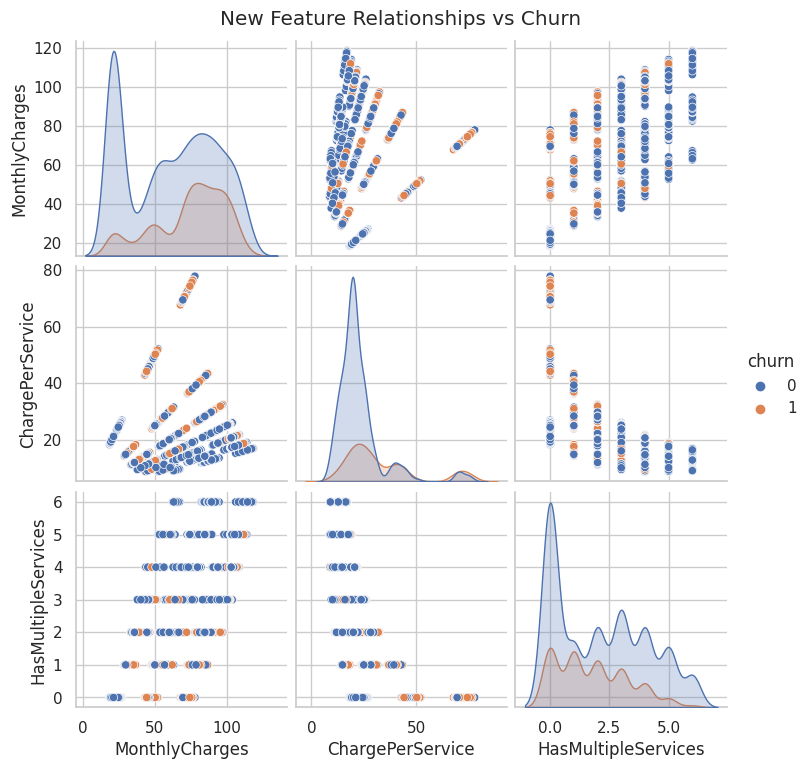

In [6]:
if "tenure" in df.columns:
    df["AvgChargesPerMonth"] = df["TotalCharges"] / (df["tenure"] + 1)

# Number of active add-on services
service_cols = [c for c in ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                            "TechSupport", "StreamingTV", "StreamingMovies"] if c in df.columns]
df["HasMultipleServices"] = (df[service_cols] == "Yes").sum(axis=1)

# Contract type and payment convenience
if "Contract" in df.columns:
    df["IsLongTermContract"] = df["Contract"].isin(["One year", "Two year"]).astype(int)
if "PaymentMethod" in df.columns:
    df["IsAutoPayment"] = df["PaymentMethod"].str.contains("automatic", case=False, na=False).astype(int)

print("Feature engineering completed. New columns added:",
      [c for c in df.columns if c not in contract.columns])

if "MonthlyCharges" in df.columns and "HasMultipleServices" in df.columns:
    df["ChargePerService"] = df["MonthlyCharges"] / (df["HasMultipleServices"] + 1)

if "tenure" in df.columns and "HasMultipleServices" in df.columns:
    df["TenureToContractRatio"] = df["tenure"] / (df["HasMultipleServices"] + 1)

if "SeniorCitizen" in df.columns and "TechSupport" in df.columns:
    df["IsSeniorWithTechSupport"] = (
        (df["SeniorCitizen"] == 1) & (df["TechSupport"] == "Yes")
    ).astype(int)

new_cols = ["ChargePerService", "TenureToContractRatio", "IsSeniorWithTechSupport"]
print("🔧 Added interaction features:", new_cols)

sns.pairplot(df[["MonthlyCharges", "ChargePerService", "HasMultipleServices", "churn"]],
             hue="churn", diag_kind="kde")
plt.suptitle("New Feature Relationships vs Churn", y=1.02)
plt.show()


In [7]:
X = df.drop(columns=["churn"])
y = df["churn"]

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

low_card_cat = [c for c in cat_features if X[c].nunique() <= 50]
high_card_cat = [c for c in cat_features if X[c].nunique() > 50]

In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [9]:
low_cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [10]:
high_cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("low_cat", low_cat_transformer, low_card_cat),
    ("high_cat", high_cat_transformer, high_card_cat)
])

In [12]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Training+Validation size: {X_trainval.shape[0]} | Test size: {X_test.shape[0]}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Training+Validation size: 5634 | Test size: 1409


In [13]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=30,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

In [14]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="auc",
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

In [15]:
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

In [16]:
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_trainval, y_trainval, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_results[name] = scores
    print(f"\n{name} AUC-ROC (CV mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print("Best model by validation AUC: {best_model_name}")


Random Forest AUC-ROC (CV mean ± std): 0.8176 ± 0.0124


/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClas


XGBoost AUC-ROC (CV mean ± std): 0.8339 ± 0.0083
Best model by validation AUC: {best_model_name}


In [17]:
best_model = models[best_model_name]
best_model.fit(X_trainval, y_trainval)

/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen',
                                                   'HasMultipleServices',
                                                   'IsAutoPayment',
                                                   'ChargePerService',
                                                   'IsSeniorWithTechSupport']),
                                                 ('low_cat',
       

In [18]:
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

auc_final = roc_auc_score(y_test, y_proba_test)
acc_final = accuracy_score(y_test, y_pred_test)
prec_final = precision_score(y_test, y_pred_test)
rec_final = recall_score(y_test, y_pred_test)
f1_final = f1_score(y_test, y_pred_test)

print("\n=== FINAL TEST PERFORMANCE (UNSEEN DATA) ===")
print(f"AUC-ROC:  {auc_final:.4f}")
print(f"Accuracy: {acc_final:.4f}")
print(f"Precision:{prec_final:.4f}")
print(f"Recall:   {rec_final:.4f}")
print(f"F1:       {f1_final:.4f}")


=== FINAL TEST PERFORMANCE (UNSEEN DATA) ===
AUC-ROC:  0.8342
Accuracy: 0.7899
Precision:0.6300
Recall:   0.5053
F1:       0.5608


In [19]:
joblib.dump(best_model, "final_churn_model_fair_test.joblib")

results = pd.DataFrame({
    "Model": list(cv_results.keys()),
    "CV_AUC_Mean": [v.mean() for v in cv_results.values()],
    "CV_AUC_Std": [v.std() for v in cv_results.values()]
})

results["Best_Model"] = best_model_name
results["Final_Test_AUC"] = auc_final
results.to_csv("final_model_results_fair.csv", index=False)

print("Model and CV results saved to 'final_model_results_fair.csv'")

Model and CV results saved to 'final_model_results_fair.csv'
